# Preprocess

## Dataset

[New York Citi Bike Trip Histories](https://www.citibikenyc.com/system-data)

Use [201707-citibike-tripdata.csv.zip](https://s3.amazonaws.com/tripdata/201707-citibike-tripdata.csv.zip) as dataset

## Schema

- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

This data has been processed to remove trips that are taken by staff as they service and inspect the system, trips that are taken to/from any of our “test” stations (which we were using more in June and July 2013), and any trips that were below 60 seconds in length (potentially false starts or users trying to re-dock a bike to ensure it's secure).

### Import packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import great_circle
from sklearn.metrics.pairwise import euclidean_distances
from scipy import signal
%matplotlib inline

### Read csv to dataframe

use pandas to read data

In [4]:
df = pd.read_csv('./201707-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,364,2017-07-01 00:00:00,2017-07-01 00:06:05,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,14744,Subscriber,1986.0,1
1,2142,2017-07-01 00:00:03,2017-07-01 00:35:46,293,Lafayette St & E 8 St,40.730207,-73.991026,3425,2 Ave & E 104 St,40.789210,-73.943708,19587,Subscriber,1981.0,1
2,328,2017-07-01 00:00:08,2017-07-01 00:05:37,3242,Schermerhorn St & Court St,40.691029,-73.991834,3397,Court St & Nelson St,40.676395,-73.998699,27937,Subscriber,1984.0,2
3,2530,2017-07-01 00:00:11,2017-07-01 00:42:22,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,26066,Subscriber,1985.0,1
4,2534,2017-07-01 00:00:15,2017-07-01 00:42:29,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,398,Atlantic Ave & Furman St,40.691652,-73.999979,29408,Subscriber,1982.0,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735599 entries, 0 to 1735598
Data columns (total 15 columns):
tripduration               int64
starttime                  object
stoptime                   object
start station id           int64
start station name         object
start station latitude     float64
start station longitude    float64
end station id             int64
end station name           object
end station latitude       float64
end station longitude      float64
bikeid                     int64
usertype                   object
birth year                 float64
gender                     int64
dtypes: float64(5), int64(5), object(5)
memory usage: 198.6+ MB


## Detect missing data

find out some null or NAN in dataframe, and we find NAN in birth year column

In [6]:
df.isnull().sum()

tripduration                    0
starttime                       0
stoptime                        0
start station id                0
start station name              0
start station latitude          0
start station longitude         0
end station id                  0
end station name                0
end station latitude            0
end station longitude           0
bikeid                          0
usertype                        0
birth year                 228596
gender                          0
dtype: int64

### Fill missing data with the most frequency data

because birth year is not like real number, we do not use mean to fill missing data; using the most frequency data is more proper to fix it

In [7]:
df['birth year'] = df['birth year'].fillna(df['birth year'].mode()[0])
df.isnull().sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
dtype: int64

## Detect strange data

detect and fix thhe data

In [8]:
df.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender
count,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06,1.735599e+06
mean,1.060143e+03,1.371501e+03,4.073562e+01,-7.398510e+01,1.370967e+03,4.073536e+01,-7.398519e+01,2.317056e+04,1.980699e+03,1.095545e+00
std,9.622457e+03,1.348571e+03,2.859067e-02,1.744022e-02,1.348952e+03,2.855812e-02,1.747490e-02,4.988904e+03,1.114420e+01,5.978624e-01
min,6.100000e+01,7.200000e+01,4.065540e+01,-7.401713e+01,7.200000e+01,4.065540e+01,-7.406692e+01,1.452900e+04,1.874000e+03,0.000000e+00
25%,3.950000e+02,3.590000e+02,4.071740e+01,-7.399725e+01,3.590000e+02,4.071723e+01,-7.399726e+01,1.840200e+04,1.974000e+03,1.000000e+00
50%,6.760000e+02,4.860000e+02,4.073625e+01,-7.398765e+01,4.850000e+02,4.073588e+01,-7.398766e+01,2.519100e+04,1.985000e+03,1.000000e+00
75%,1.183000e+03,3.142000e+03,4.075514e+01,-7.397575e+01,3.141000e+03,4.075510e+01,-7.397605e+01,2.773400e+04,1.988000e+03,1.000000e+00
max,2.477222e+06,3.478000e+03,4.088092e+01,-7.389660e+01,3.478000e+03,4.088092e+01,-7.389660e+01,3.033700e+04,2.001000e+03,2.000000e+00


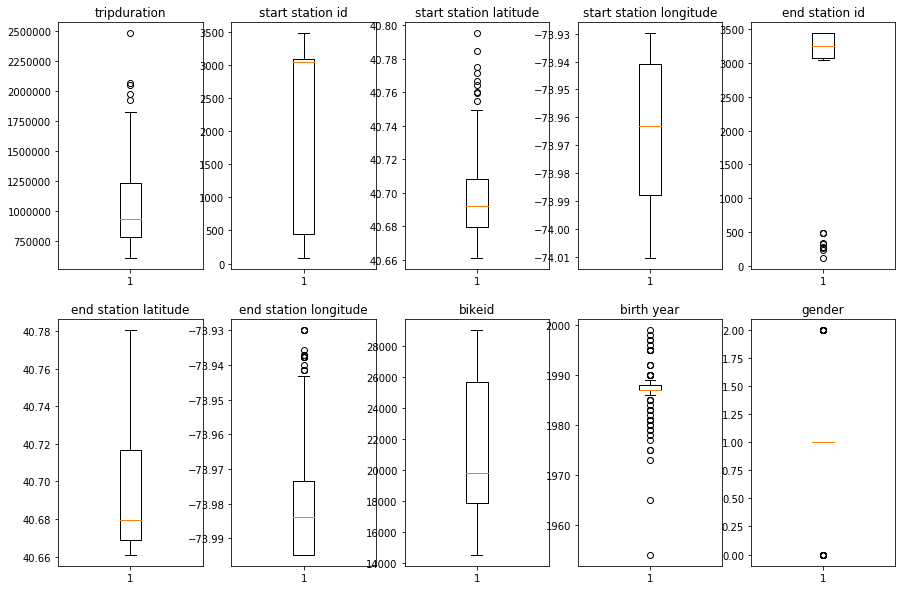

In [19]:
def show_box():
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15,10))
    i = 1
    for col in df.columns:
        if df[col].dtype == np.float64 or df[col].dtype == np.int64:
            ax = plt.subplot(2, 5, i)
            plt.boxplot(df[col])
            ax.set_title(col)
            i += 1
    plt.show()

show_box()

### Remove strange data

- tripduration
  - The time exceed a week could be forgot to return
- birth year < 1917
  - The 100-year-old people are alomst impossible to ride bike

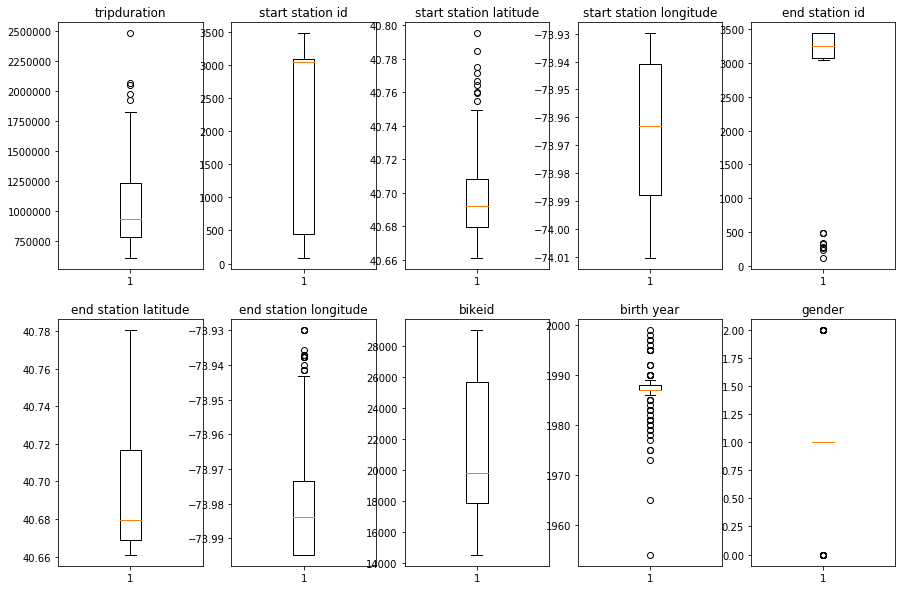

In [20]:
df = df.drop(df[df['tripduration'] < 7 * 86400].index)
df = df.drop(df[df['birth year'] < 1917].index)
show_box()

### Detect unique station id map to station name

In [10]:
x1 = len(df['start station id'].unique())
y1 = len(df[['start station id', 'start station name']].drop_duplicates())
x2 = len(df['end station id'].unique())
y2 = len(df[['end station id', 'end station name']].drop_duplicates())

x1 == y1 and x2 == y2

True

### Detect unique station id map to station latitude

In [11]:
x1 = len(df['start station id'].unique())
y2 = len(df[['start station id', 'start station latitude']].drop_duplicates())
x2 = len(df['end station id'].unique())
y2 = len(df[['end station id', 'end station latitude']].drop_duplicates())

x1 == y1 and x2 == y2

True

### Detect unique station id map to station longitude

In [12]:
x1 = len(df['start station id'].unique())
y2 = len(df[['start station id', 'start station longitude']].drop_duplicates())
x2 = len(df['end station id'].unique())
y2 = len(df[['end station id', 'end station longitude']].drop_duplicates())

x1 == y1 and x2 == y2

True

## Translate time to every hour stamp and detect strange time

make in_flow and out_flow generate more easily, so we translate time to timestamp that repersents how many hours from 2017-07-01 00:00:00; and also check timestamp should be positive

In [14]:
import plotly.plotly as py
from plotly.graph_objs import *

ImportError: No module named plotly.plotly

In [13]:
def timestamp(df):
    tmp = []
    t0 = datetime(2017, 7, 1, 0, 0)
    for row in df.itertuples():
        t1 = datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S')
        tm = int((t1 - t0).total_seconds() // 1800)
        assert tm >= 0
        tmp.append(tm)
    df.insert(loc = 0, column = 'timestamp', value = tmp)

start_df = df[['starttime', 'start station id']]
timestamp(start_df)
end_df = df[['stoptime', 'end station id']]
timestamp(end_df)
# start_df
end_df

NameError: global name 'datetime' is not defined

## Calculate station number

append two columns and put them into set, so we can use len function to know the station number

In [ ]:
station_id = list(set(df['start station id'].tolist() + df['end station id'].tolist()))
station_num = len(station_id)
station_num

## Calculate in_flow and out_flow

use end_df and start_df to sum every timestamp, and the outcome is in_flow and out_flow

In [ ]:
def cnt_flow(df):
    flow = pd.DataFrame(np.zeros((48 * 31, station_num)), columns = station_id)
    for row in df.itertuples():
        if row[1] < 48 * 31:
            flow.loc[row[1], row[3]] += 1
    return flow

in_flow = cnt_flow(end_df)
out_flow = cnt_flow(start_df)
in_flow.to_csv('in_flow.csv')
out_flow.to_csv('out_flow.csv')
out_flow


# Query

## 1. How many stations are there in this dataset, and what is the average distance between them?

there are 634 stations and the average distance between them is 10877.7798769 meters

In [ ]:
start_station = df[['start station id', 'start station name', 'start station latitude', 'start station longitude']]
start_station.columns = ['station id', 'station name', 'station latitude', 'station logitude']
end_station = df[['end station id', 'end station name', 'end station latitude', 'end station longitude']]
end_station.columns = ['station id', 'station name', 'station latitude', 'station logitude']

station = start_station.append(end_station, ignore_index = True)
station = station.drop_duplicates()
station = station.reset_index(drop = True)
station_num = len(station)
station

use great circle to calculate distance

In [ ]:
dist_sum = 0
for i in xrange(station_num):
    for j in xrange(station_num):
        if i != j:
            a = (station.iloc[i, 2], station.iloc[i, 3])
            b = (station.iloc[j, 2], station.iloc[j, 3])
            dist_sum += great_circle(a, b).meters

print dist_sum / float(station_num * (station_num - 1) / 2)

## 2. What are the top 3 frequent stations pairs (start stations, end stations) in weekdays, how about in weekends?

represent station by station id

- weekdays
    1. (432, 3263) 656
    2. (2006, 2006) 547
    3. (281, 281) 499


- weekends
    1. (3182, 3182) 889
    2. (3182, 3254) 829
    3. (3254, 3182) 818

In [ ]:
pair_station = df[['start station id', 'end station id', 'starttime', 'stoptime']]
pair_station

In [ ]:
pair = {}
for row in pair_station.itertuples():
    d = datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
    d = 'weekday' if d.isoweekday() < 6 else 'weekend'
    if pair.get((row[1], row[2], d)):
        pair[(row[1], row[2], d)] += 1
    else:
        pair[(row[1], row[2], d)] = 1
pair = sorted(pair.items(), key=lambda d: d[1])
end_cnt = 0
day_cnt = 0
for key, val in pair[::-1]:
    if end_cnt >= 3 and day_cnt >= 3:
        break
    if 'weekend' in key and end_cnt < 3:
        end_cnt += 1
        print key, val
    if 'weekday' in key and day_cnt < 3:
        day_cnt += 1
        print key, val

## 3. Find the top 3 stations with highest average out-flow, and top 3 highest average in-flow

represent station by station id

### Top 3 stations with highest average out-flow

In [ ]:
mean_out_flow = pd.DataFrame(out_flow.mean().tolist(), station_id, columns = ['average flow'])
mean_out_flow.nlargest(3, 'average flow')

### Top 3 stations with highest average in-flow

In [ ]:
mean_in_flow = pd.DataFrame(in_flow.mean().tolist(), station_id, columns = ['average flow'])
mean_in_flow.nlargest(3, 'average flow')

## 4. What is the most popular station (highest average inflow + outflow)?

In [ ]:
(mean_in_flow + mean_out_flow).nlargest(1, 'average flow')

### Define function to plot picture and calculate the distance

In [ ]:
def cal_and_draw(in_df, out_df):
    p_in_flow = in_df.tolist()
    p_out_flow = out_df.tolist()
    plt.figure(figsize = (16, 4))
    plt.plot(p_in_flow)
    plt.plot(p_out_flow)
    plt.show()
    print euclidean_distances(np.array(p_in_flow).reshape(1, -1), np.array(p_out_flow).reshape(1, -1))[0][0]

### Draw the in-flow(A) and out-flow(B) for that station in a line chart
### Calculate the distance function between A and B with euclidean distance

In [ ]:
p_in_flow = in_flow[519]
p_out_flow = out_flow[519]
cal_and_draw(p_in_flow, p_out_flow)

### Calculate the distance function between A - mean(A) and B - mean(B) , and draw them both

In [ ]:
cal_and_draw(p_in_flow - p_in_flow.mean(), p_out_flow - p_out_flow.mean())

### Calculate the distance function between (A - mean(A)) / std(A) and (B - mean(B)) / std(B) , and draw them both

In [ ]:
cal_and_draw((p_in_flow - p_in_flow.mean()) / p_in_flow.std(), (p_out_flow - p_out_flow.mean()) / p_out_flow.std())

### Calculate the distance function between {Ai − f(i) | Ai ∈ A} and {Bi − f(i) | Bi ∈ B} , and draw them both

remove linear trend along axis from data with scipy.signal.detrend

In [ ]:
cal_and_draw(signal.detrend(p_in_flow), signal.detrend(p_out_flow))

### Calculate the distance function between Smooth(A) and Smooth(B) , and draw them both

#### Smooth with a Savitzky-Golay filter

the window-length = 5 means smooth over a 2-hour (120 minute) window

In [ ]:
cal_and_draw(signal.savgol_filter(p_in_flow, window_length = 5, polyorder = 0), signal.savgol_filter(p_out_flow, window_length = 5, polyorder = 0))

## 5. Please try to find some interesting query or observation in the dataset

### Calculate average trip duration with gender

- male 901.685699446 sec
- female 1017.37209273 sec
- unknown 1873.76102282 sec

In [ ]:
duration_df = df[['tripduration', 'gender']]

male_sum = 0
male = 0
female_sum = 0
female = 0
unknown_sum = 0
unknown = 0

for row in duration_df.itertuples():
    gen = row[2]
    if gen == 0:
        unknown += 1
        unknown_sum += row[1]
    elif gen == 1:
        male += 1
        male_sum += row[1]
    elif gen == 2:
        female += 1
        female_sum += row[1]

print float(male_sum) / float(male)
print float(female_sum) / float(female)
print float(unknown_sum) / float(unknown)

### The station which is most females visited

represent station by station id

in 426 station, there are most females, so we can visit there often XD

In [ ]:
def keywithmaxval(d):
    v = list(d.values())
    k = list(d.keys())
    return k[v.index(max(v))]

tra_df = df[['start station id', 'end station id', 'gender']]
cnt = {}
for row in tra_df.itertuples():
    if row[3] == 2:
        if cnt.get(row[1]):
            cnt[row[1]] += 1
        else:
            cnt[row[1]] = 1
        if cnt.get(row[2]):
            cnt[row[2]] += 1
        else:
            cnt[row[2]] = 1
keywithmaxval(cnt)